Proyecto mostrando la predicciones de un Time Series.  
Se uso la data de consumo de energia (data horaria) de PJM (empresa de energia en USA) para la seccion Este.

In [60]:
import pandas as  pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error

palet_color = sns.color_palette()
plt.style.use('fivethirtyeight')

In [61]:
df = pd.read_csv('PJME_hourly.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

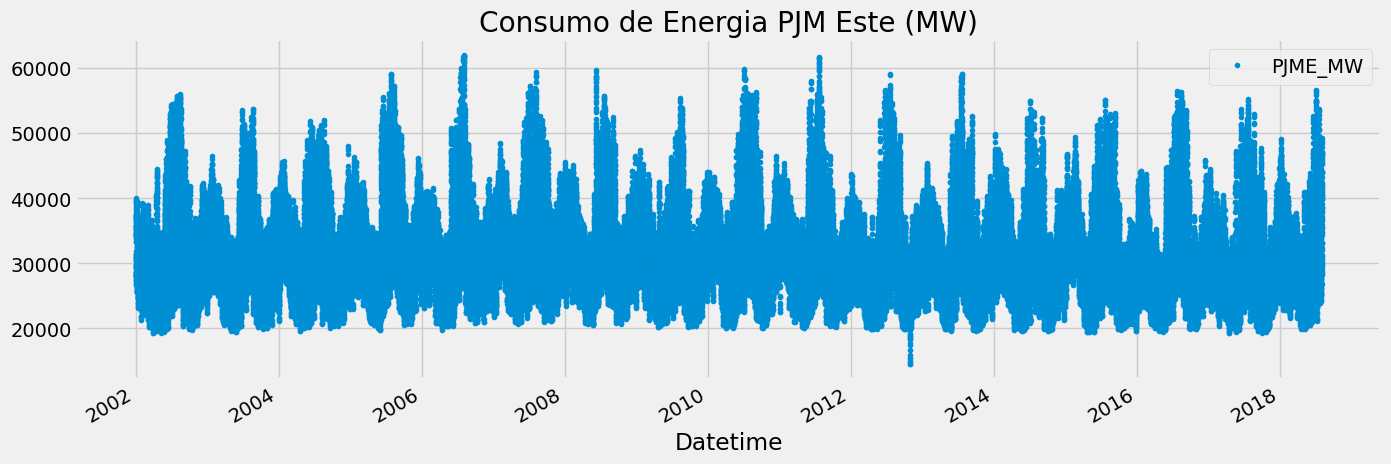

In [62]:
df.plot(style='.',
        figsize=(15, 5),
        color=palet_color[0],
        title='Consumo de Energia PJM Este (MW)',
        fontsize=14)
plt.show()

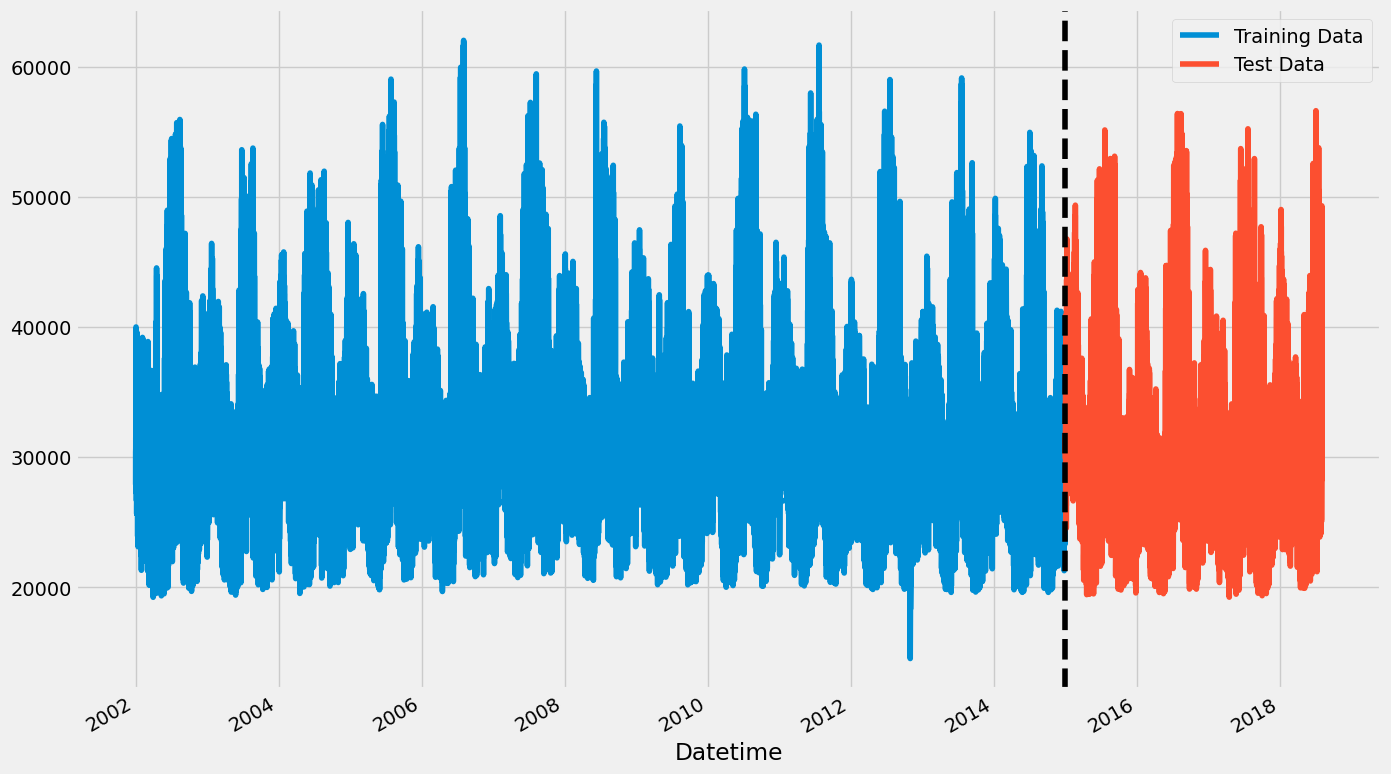

In [63]:
train_data = df.loc[df.index < '2015-01-01']
test_data = df.loc[df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 10))
train_data.plot(ax=ax, label='Training Data')
test_data.plot(ax=ax, label='Test Data')
ax.axvline('2015-01-01', color='black', linestyle='--')
plt.legend(['Training Data', 'Test Data'])
plt.show()

<Axes: title={'center': 'Una semana de data'}, xlabel='Datetime'>

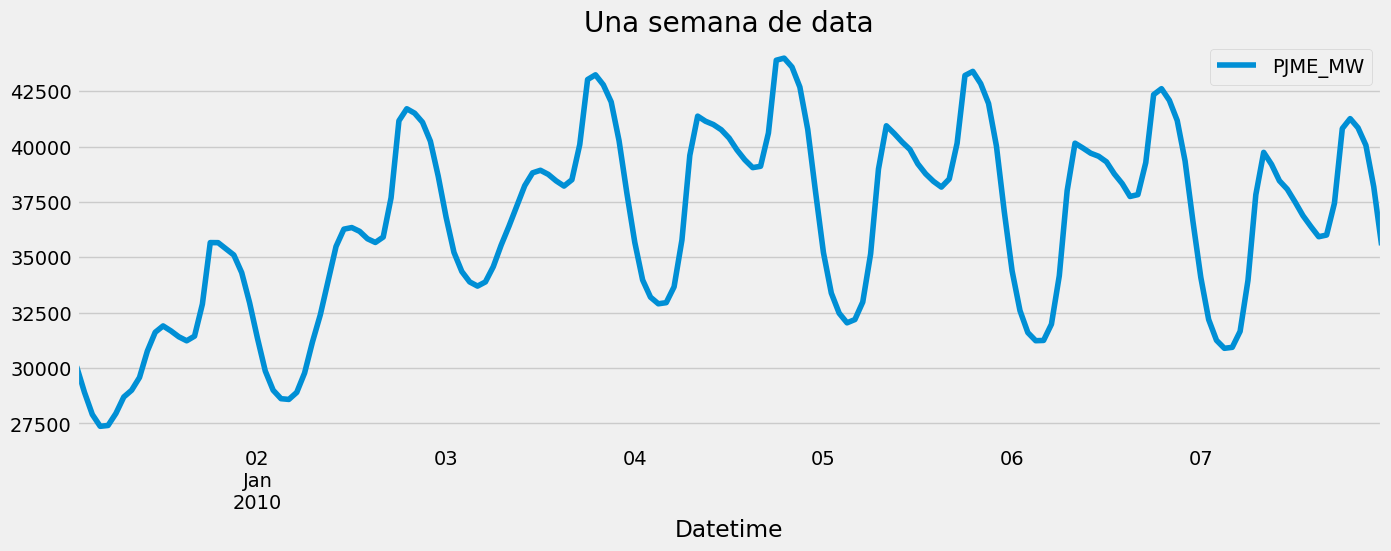

In [64]:
#  Visualizando una semana de data

df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].sort_index().plot(
    figsize=(15, 5),
    title='Una semana de data')


In [65]:
# Featrue Engineering
def creacion_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    return df

In [66]:
df = creacion_features(df)
df

,PJME_MW,year,month,dayofyear,hour,dayofweek,quarter
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,2002,12,365,1,1,4
2002-12-31 02:00:00,25147.0,2002,12,365,2,1,4
2002-12-31 03:00:00,24574.0,2002,12,365,3,1,4
2002-12-31 04:00:00,24393.0,2002,12,365,4,1,4
2002-12-31 05:00:00,24860.0,2002,12,365,5,1,4
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018,1,1,20,0,1
2018-01-01 21:00:00,43751.0,2018,1,1,21,0,1
2018-01-01 22:00:00,42402.0,2018,1,1,22,0,1


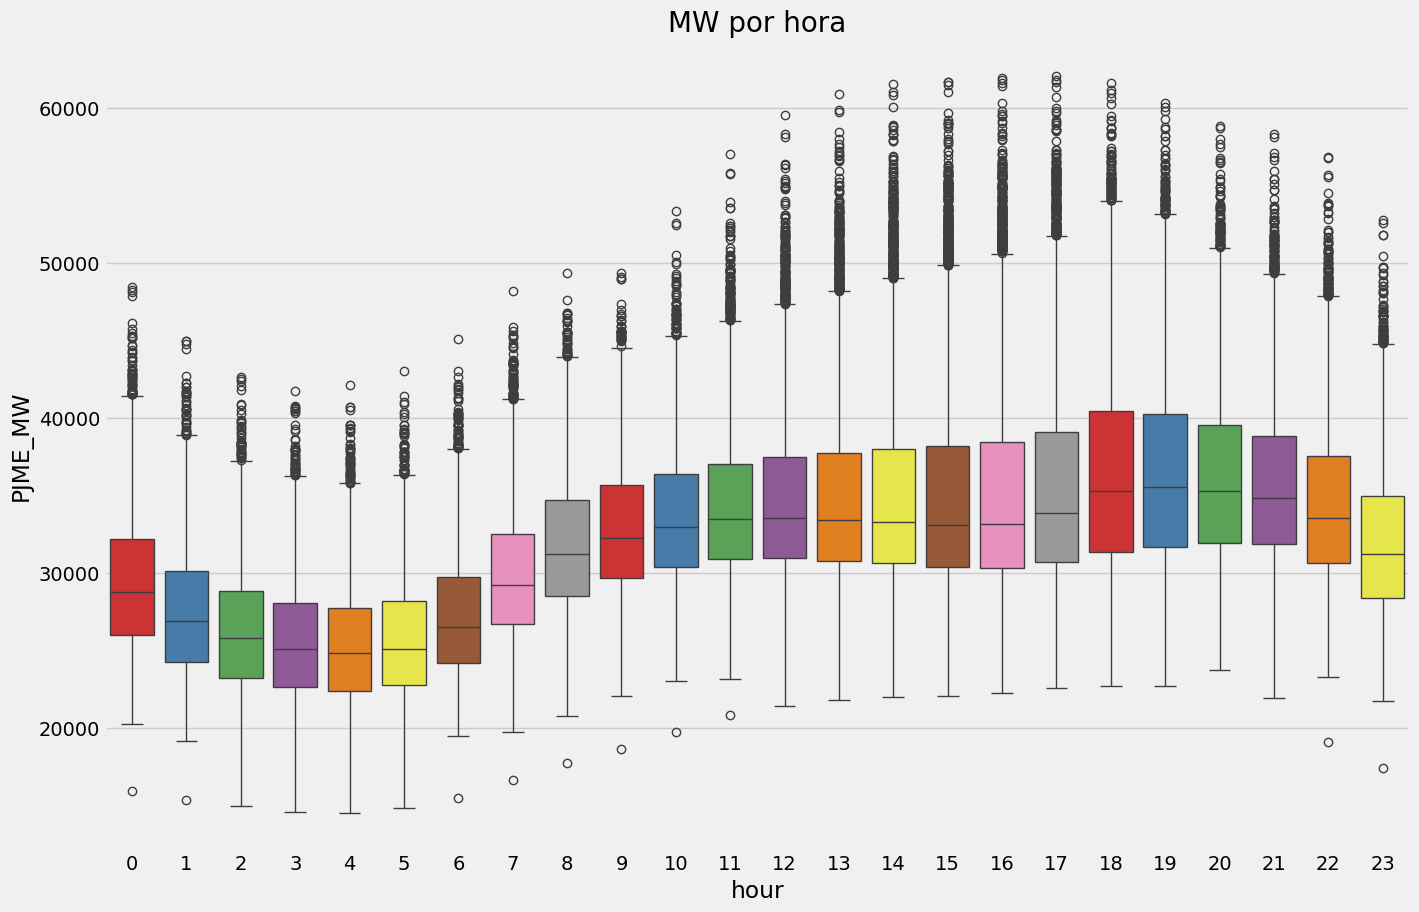

In [67]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=df, x='hour', y='PJME_MW', hue='hour',legend=False,palette='Set1')
ax.set_title("MW por hora", fontsize=20)
plt.show()

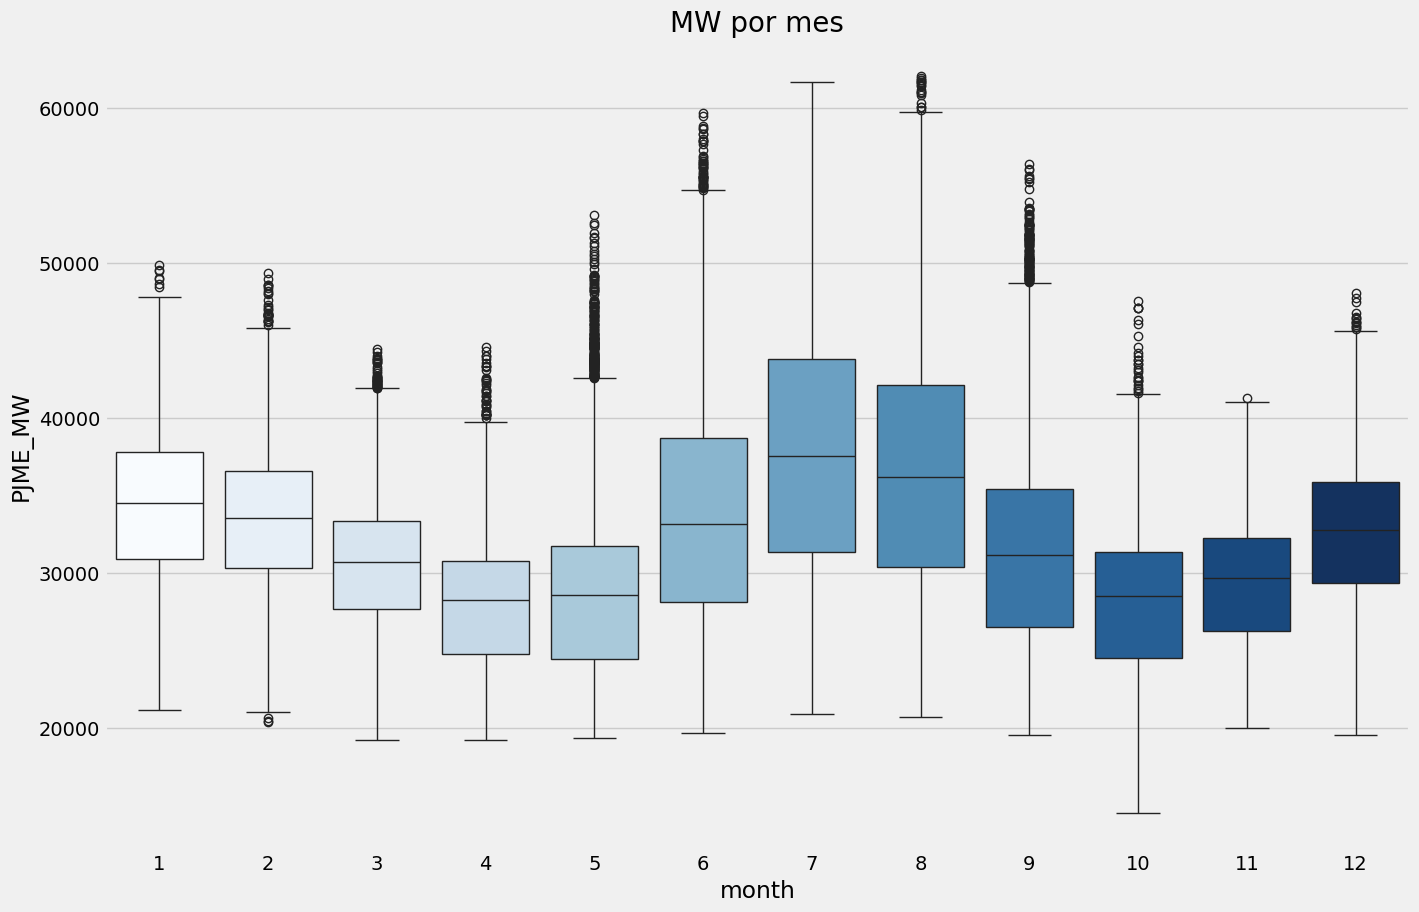

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=df, x='month', y='PJME_MW', hue='month',legend=False,palette='Blues')
ax.set_title("MW por mes", fontsize=20)
plt.show()

In [69]:
train_data = creacion_features(train_data)
test_data = creacion_features(test_data)

predictores = ['year', 'month', 'dayofyear', 'hour', 'dayofweek', 'quarter']
target = 'PJME_MW'

In [70]:
X_train = train_data[predictores]
y_train = train_data[target]

X_test = test_data[predictores]
y_test = test_data[target]

In [71]:
# Creacion del Modelo usando XGB

ts_model_xgb = XGBRegressor(n_estimators= 10000,
                            learning_rate=0.01,
                            early_stopping_rounds=50)

In [72]:

ts_model_xgb.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_test, y_test)],
                 verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76641
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.87768
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.19834


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


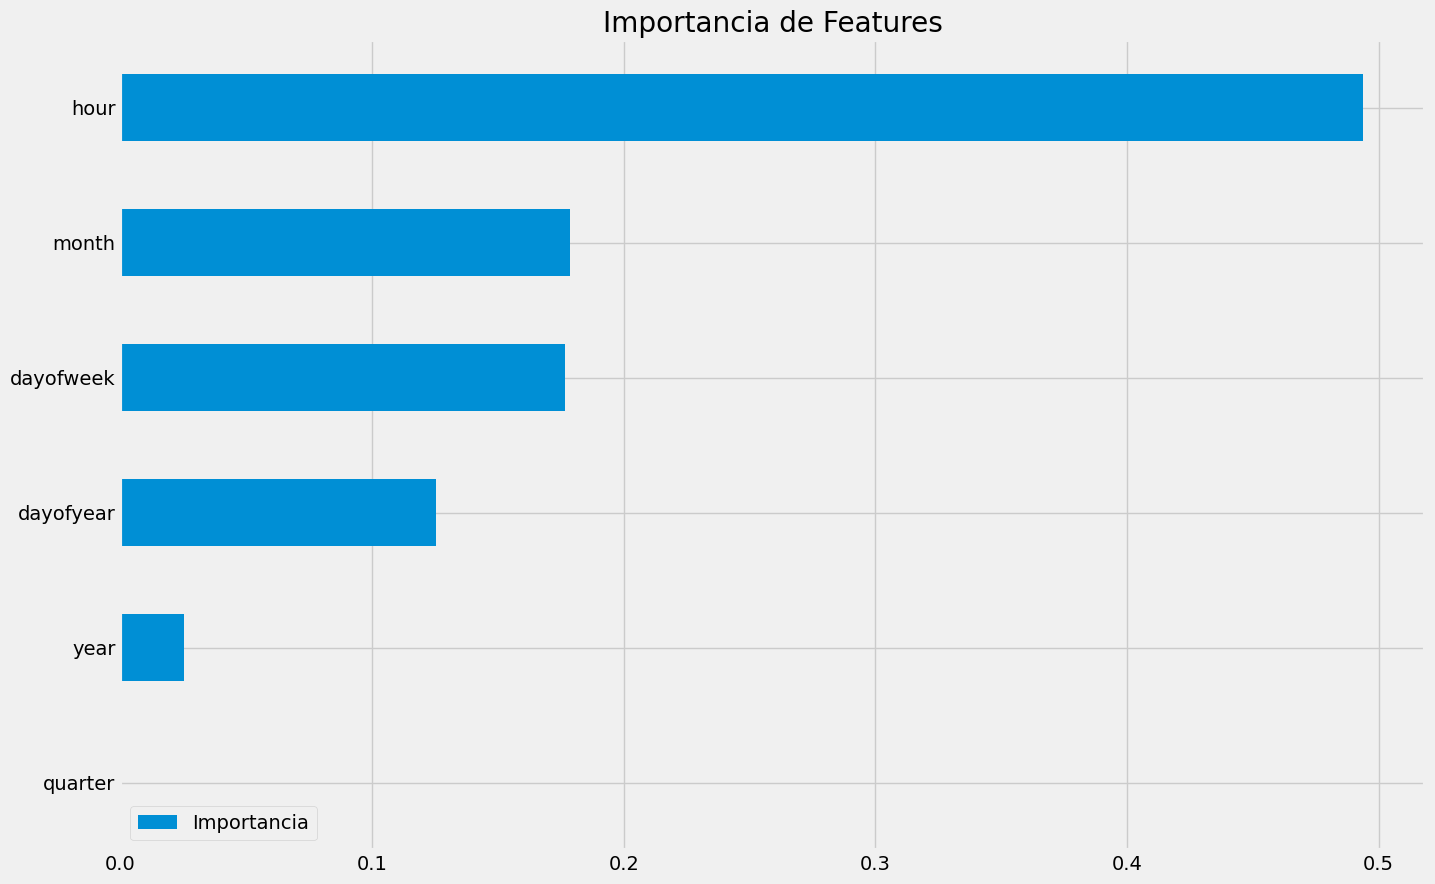

In [73]:
fig, ax = plt.subplots(figsize=(15, 10))
pd.DataFrame(data =ts_model_xgb.feature_importances_,
             index=ts_model_xgb.feature_names_in_,
             columns=['Importancia']).sort_values(by='Importancia',ascending=True).plot(ax=ax,kind='barh',
                                                                                         title='Importancia de Features')
plt.show()

In [74]:
# Predicciones en la data de testeo
y_pred = ts_model_xgb.predict(X_test)
test_data['predicciones'] = y_pred
test_data

,PJME_MW,year,month,dayofyear,hour,dayofweek,quarter,predicciones
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,2015,1,1,0,3,1,32393.351562
2015-12-31 01:00:00,24305.0,2015,12,365,1,3,4,29040.167969
2015-12-31 02:00:00,23156.0,2015,12,365,2,3,4,27877.017578
2015-12-31 03:00:00,22514.0,2015,12,365,3,3,4,27576.720703
2015-12-31 04:00:00,22330.0,2015,12,365,4,3,4,27576.720703
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018,1,1,20,0,1,38623.246094
2018-01-01 21:00:00,43751.0,2018,1,1,21,0,1,38495.484375
2018-01-01 22:00:00,42402.0,2018,1,1,22,0,1,36229.527344


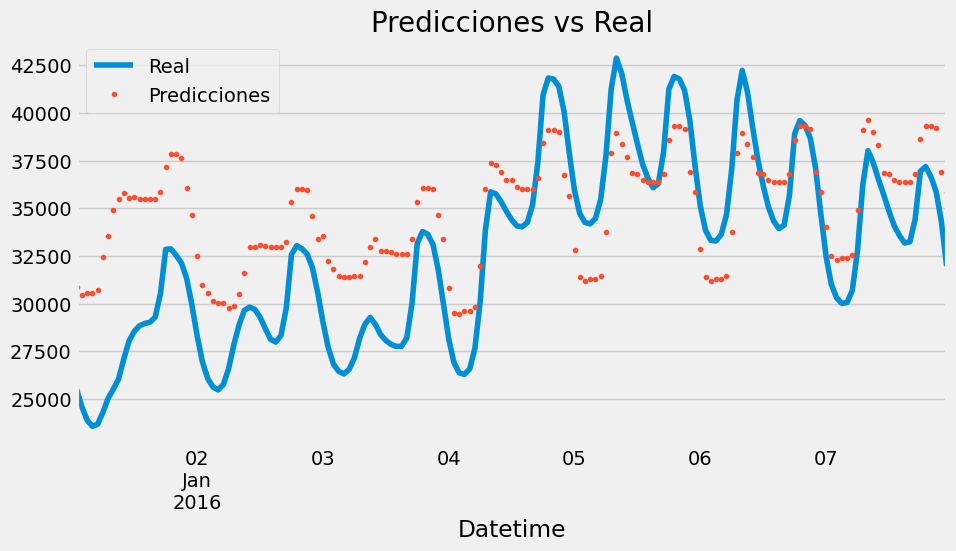

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[(df.index > '2016-01-01') & (df.index < '2016-01-08')]['PJME_MW'].sort_index().plot(ax=ax)
test_data.loc[(test_data.index > '2016-01-01') & (test_data.index < '2016-01-08')]['predicciones'].sort_index().plot(
    ax=ax,
    style='.')
ax.set_title('Predicciones vs Real', fontsize=20)
ax.legend(['Real', 'Predicciones'])
plt.show()

In [76]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 3741.0469899115005


Es posible mejorar la precisión del modelo considerando la temporalidad y ajustando sus hyperparámetros [Para fines del proyecto se uso los valores default].  
Tambien es posible usar información externa para alimentar el modelo, Ej. Las condiciones atmosféricas que ocurrieron en el periodo de tiempo estudiado, dias festivos , problema en suministro de energia, etc

# MEJORANDO EL PROYECTO

- Analisis de outliers

In [109]:
df_2 = pd.read_csv('PJME_hourly.csv')
df_2 = df_2.set_index('Datetime')
df_2.index = pd.to_datetime(df_2.index)
df_2.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

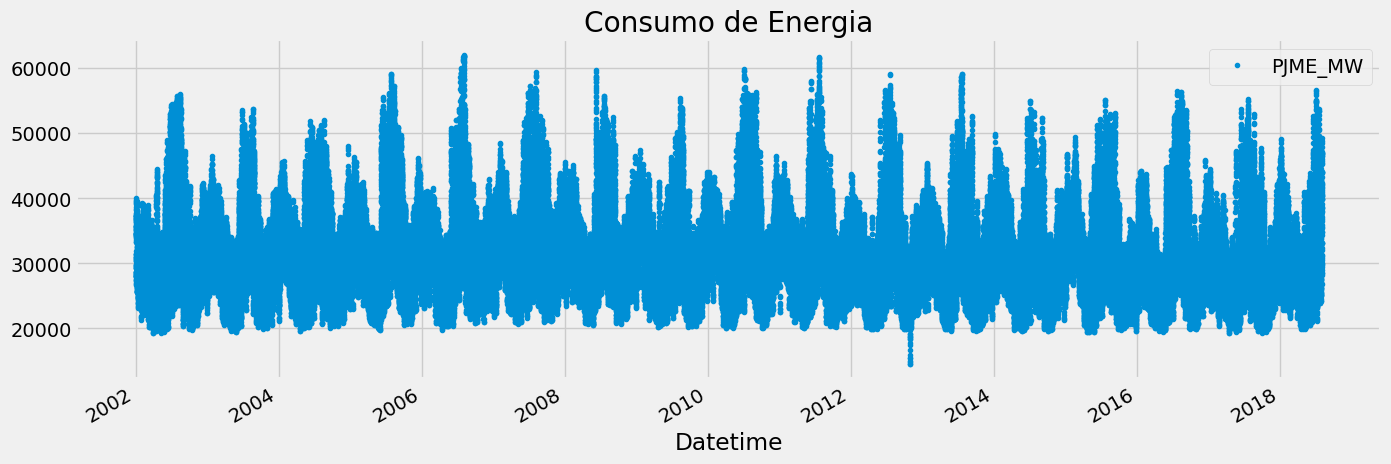

In [110]:
df_2.plot(style='.',
        figsize=(15, 5),
        color=palet_color[0],
        title='Consumo de Energia')
plt.show()

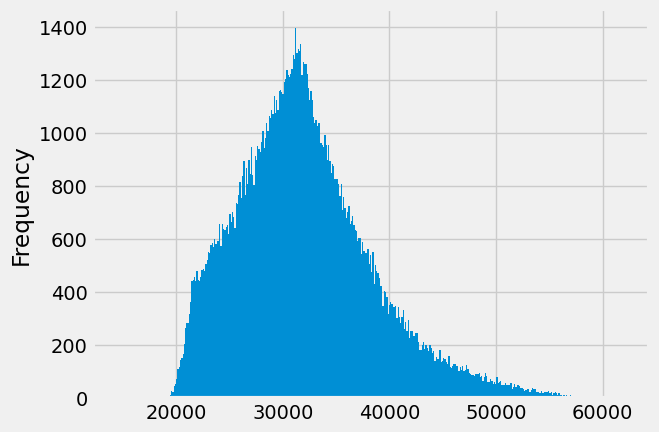

In [111]:
df_2['PJME_MW'].plot(kind='hist',bins=400)
plt.show()

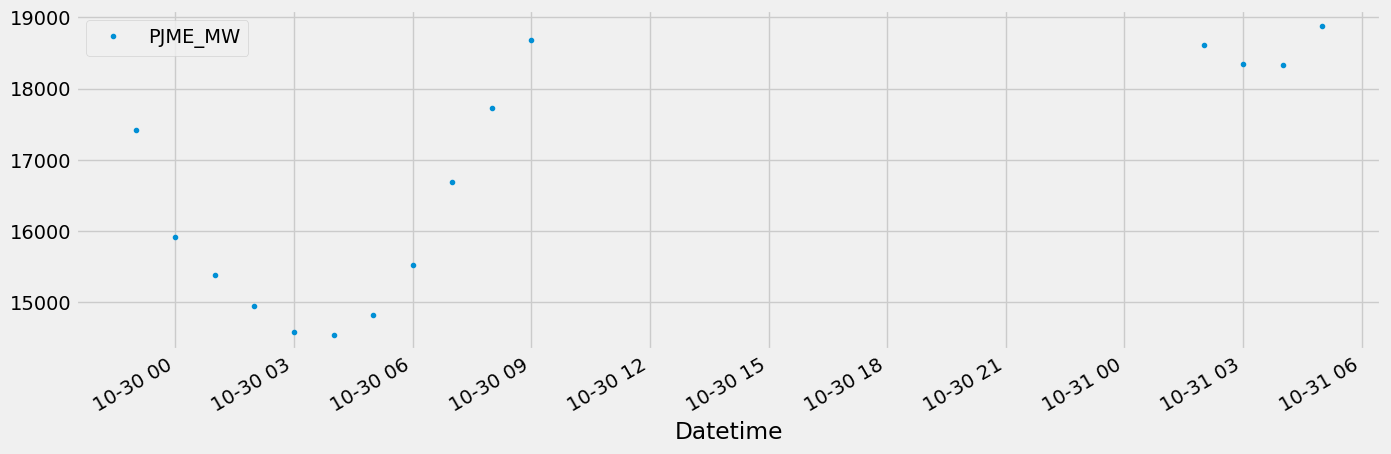

In [112]:
df_2.query('PJME_MW < 19_000').plot(figsize=(15, 5),style='.')
plt.show()

Se procede a filtrar estos valores outliers.

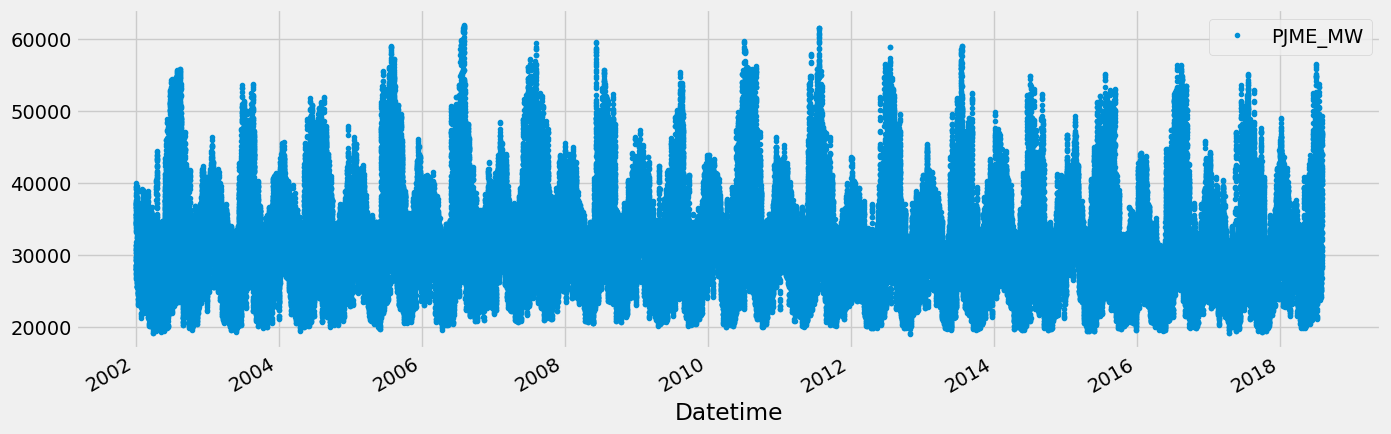

In [113]:
df_2= df_2.query('PJME_MW > 19_000').copy()
df_2.plot(figsize=(15, 5),style='.')
plt.show()

- Cross Validation

In [114]:
from sklearn.model_selection import TimeSeriesSplit

In [115]:
sts = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

df_2 = df_2.sort_index()

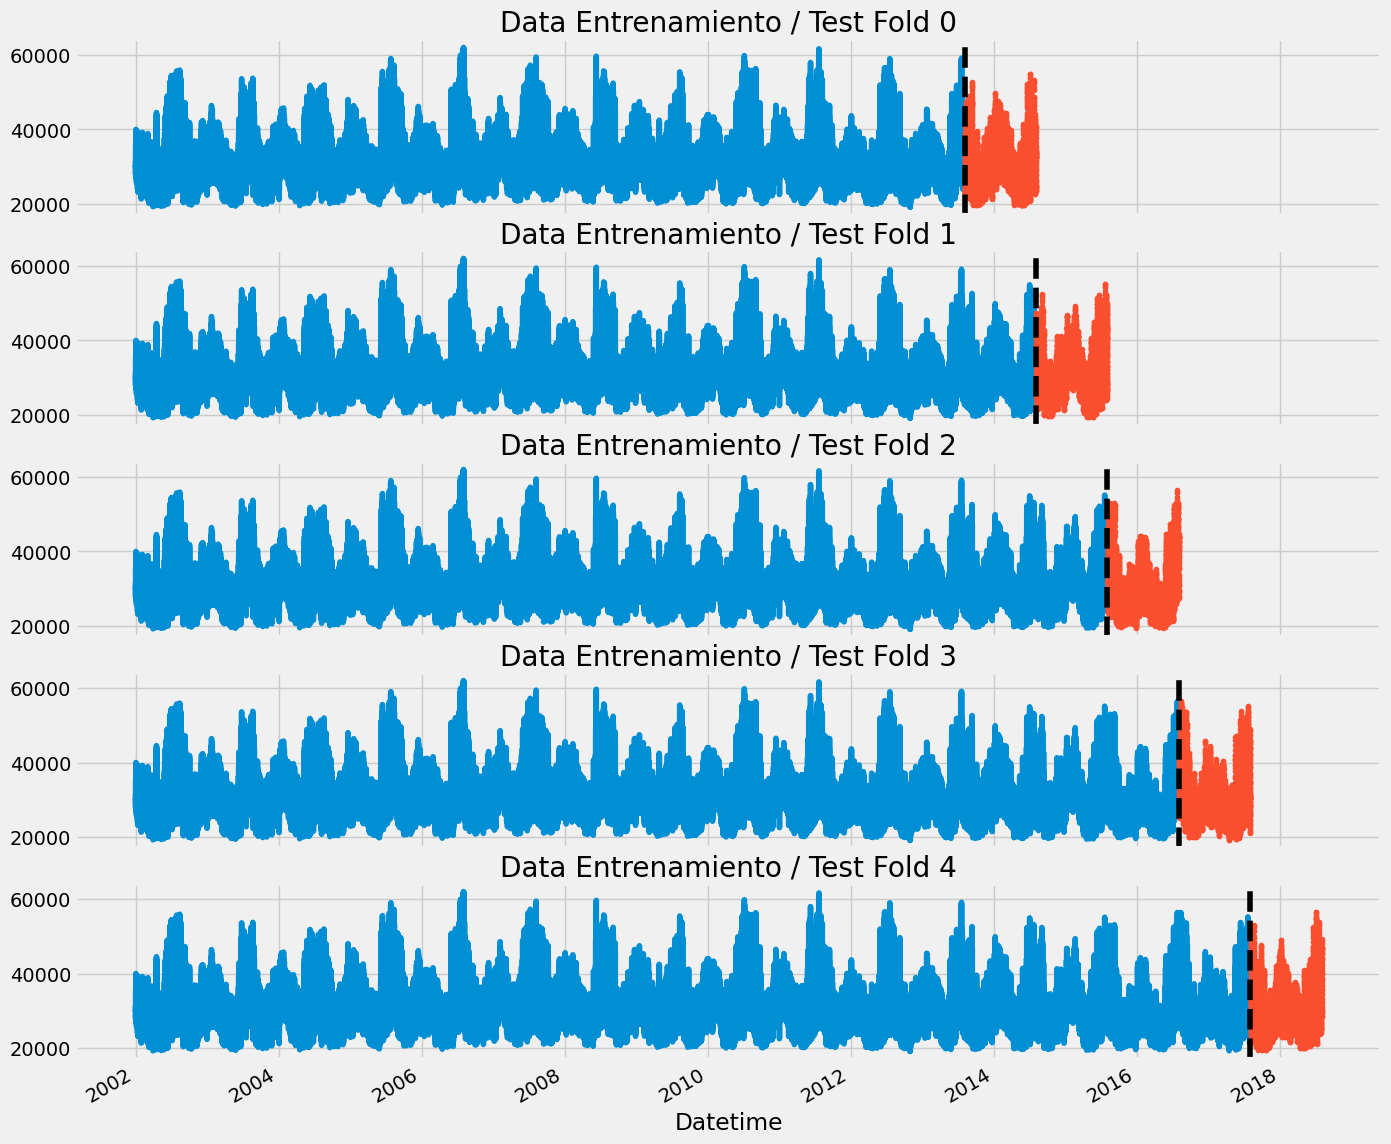

In [116]:
fig, ax = plt.subplots(5, 1, figsize=(15, 15),
                            sharex=True,)

fold = 0
for train_idx, val_idx in sts.split(df_2):
    train = df_2.iloc[train_idx]
    test = df_2.iloc[val_idx]
    train['PJME_MW'].plot(ax=ax[fold],
                          label='Data Entrenamiento',
                          title=f'Data Entrenamiento / Test Fold {fold}')
    test['PJME_MW'].plot(ax=ax[fold], style='.',
                         label='Data de Testeo')
    # plt.legend(['Entrenamiento', 'Test'])
    ax[fold].axvline(test.index.min(),color='black',linestyle='--')
    fold += 1

In [117]:
def creacion_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    return df


In [86]:
def add_lags(df):
    df['Lag_1'] = df['PJME_MW'].shift(364*24)
    df['Lag_2'] = df['PJME_MW'].shift(2 * 364 *24)
    df['Lag_3'] = df['PJME_MW'].shift(3 * 364 * 24)
    return df

In [118]:
df_2 = add_lags(df_2)

In [119]:

predic = []
scores = []

model_xgb = XGBRegressor(n_estimators=1000,base_score=0.5,
                         booster='gbtree',
                         early_stopping_rounds=50,
                         objective='reg:squarederror',
                         max_depth=3,
                         learning_rate=0.01,)

for train_idx, val_idx in sts.split(df_2):
    train = df_2.iloc[train_idx]
    test = df_2.iloc[val_idx]
    
    train = creacion_features(train)
    test = creacion_features(test)
    features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'Lag_1', 'Lag_2', 'Lag_3']
    target = 'PJME_MW'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]

    model_xgb.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=100)
    y_pred = model_xgb.predict(X_test)
    
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    predic.append(y_pred)

[0]	validation_0-rmse:32733.38600	validation_1-rmse:31956.09839
[100]	validation_0-rmse:12641.13027	validation_1-rmse:12015.44497
[200]	validation_0-rmse:5842.70447	validation_1-rmse:5545.61970
[300]	validation_0-rmse:3957.90703	validation_1-rmse:4113.88625
[400]	validation_0-rmse:3514.81068	validation_1-rmse:3931.76027
[500]	validation_0-rmse:3381.25632	validation_1-rmse:3888.17736
[600]	validation_0-rmse:3311.94798	validation_1-rmse:3873.43844
[700]	validation_0-rmse:3261.23320	validation_1-rmse:3848.53430
[800]	validation_0-rmse:3217.43644	validation_1-rmse:3790.88106
[900]	validation_0-rmse:3178.93828	validation_1-rmse:3755.91840
[971]	validation_0-rmse:3153.91455	validation_1-rmse:3750.32401
[0]	validation_0-rmse:32673.14356	validation_1-rmse:32138.41835
[100]	validation_0-rmse:12625.51307	validation_1-rmse:12145.89535
[200]	validation_0-rmse:5865.81881	validation_1-rmse:5529.44297
[300]	validation_0-rmse:3999.03536	validation_1-rmse:3938.99860
[400]	validation_0-rmse:3562.48900	v

In [120]:
print(f'Puntuacion media de todos los folds: {np.mean(scores)}')
print(f'Puntuacion de cada fold: {scores}')

Puntuacion media de todos los folds: 3694.251518460284
Puntuacion de cada fold: [np.float64(3749.997324789447), np.float64(3475.390426479078), np.float64(3434.12688407038), np.float64(3782.689699917725), np.float64(4029.053257044791)]


PREDICCIONES PARA FECHAS FUTURAS

Es necesario realizar nuevamente el entrenamiento del modelo pero ahora usando la data completa.

In [121]:
model_xgb = XGBRegressor(n_estimators=1000,
                         base_score=0.5,
                         booster='gbtree',
                         objective='reg:squarederror',
                         max_depth=3,
                         learning_rate=0.01,)
df_2 = creacion_features(df_2)
features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'Lag_1', 'Lag_2', 'Lag_3']
target = 'PJME_MW'

X_all = df_2[features]
y_all = df_2[target]

model_xgb.fit(X_all, y_all,
                eval_set=[(X_all, y_all)],
                verbose=100)



[0]	validation_0-rmse:32404.76428
[100]	validation_0-rmse:12532.87447
[200]	validation_0-rmse:5900.76114
[300]	validation_0-rmse:4093.10773
[400]	validation_0-rmse:3676.33279
[500]	validation_0-rmse:3542.22230
[600]	validation_0-rmse:3471.92086
[700]	validation_0-rmse:3419.12838
[800]	validation_0-rmse:3377.95820
[900]	validation_0-rmse:3341.77889
[999]	validation_0-rmse:3310.39639


,objective,'reg:squarederror'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [122]:
df_2.index.max()

Timestamp('2018-08-03 00:00:00')

In [123]:
futuro = pd.date_range('2018-08-03','2019-08-03',freq='h')
futuro_df = pd.DataFrame(index=futuro)
futuro_df['es_futuro'] = True
df_2['es_futuro'] = False

df2_y_futuro = pd.concat([df_2,futuro_df])


In [124]:
df2_y_futuro = creacion_features(df2_y_futuro)
df2_y_futuro = add_lags(df2_y_futuro)
df2_y_futuro

,PJME_MW,Lag_1,Lag_2,Lag_3,year,month,dayofyear,hour,dayofweek,quarter,es_futuro
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,2002,1,1,1,1,1,False
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2002,1,1,2,1,1,False
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,2002,1,1,3,1,1,False
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,2002,1,1,4,1,1,False
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,2002,1,1,5,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,NaN,41863.0,39840.0,2019,8,214,20,4,3,True
2019-08-02 21:00:00,NaN,NaN,40005.0,38664.0,2019,8,214,21,4,3,True
2019-08-02 22:00:00,NaN,NaN,37174.0,36125.0,2019,8,214,22,4,3,True
2019-08-02 23:00:00,NaN,NaN,34310.0,33373.0,2019,8,214,23,4,3,True


In [125]:
futuro_con_features = df2_y_futuro.query('es_futuro').copy()
futuro_con_features['predicciones'] = model_xgb.predict(futuro_con_features[features])

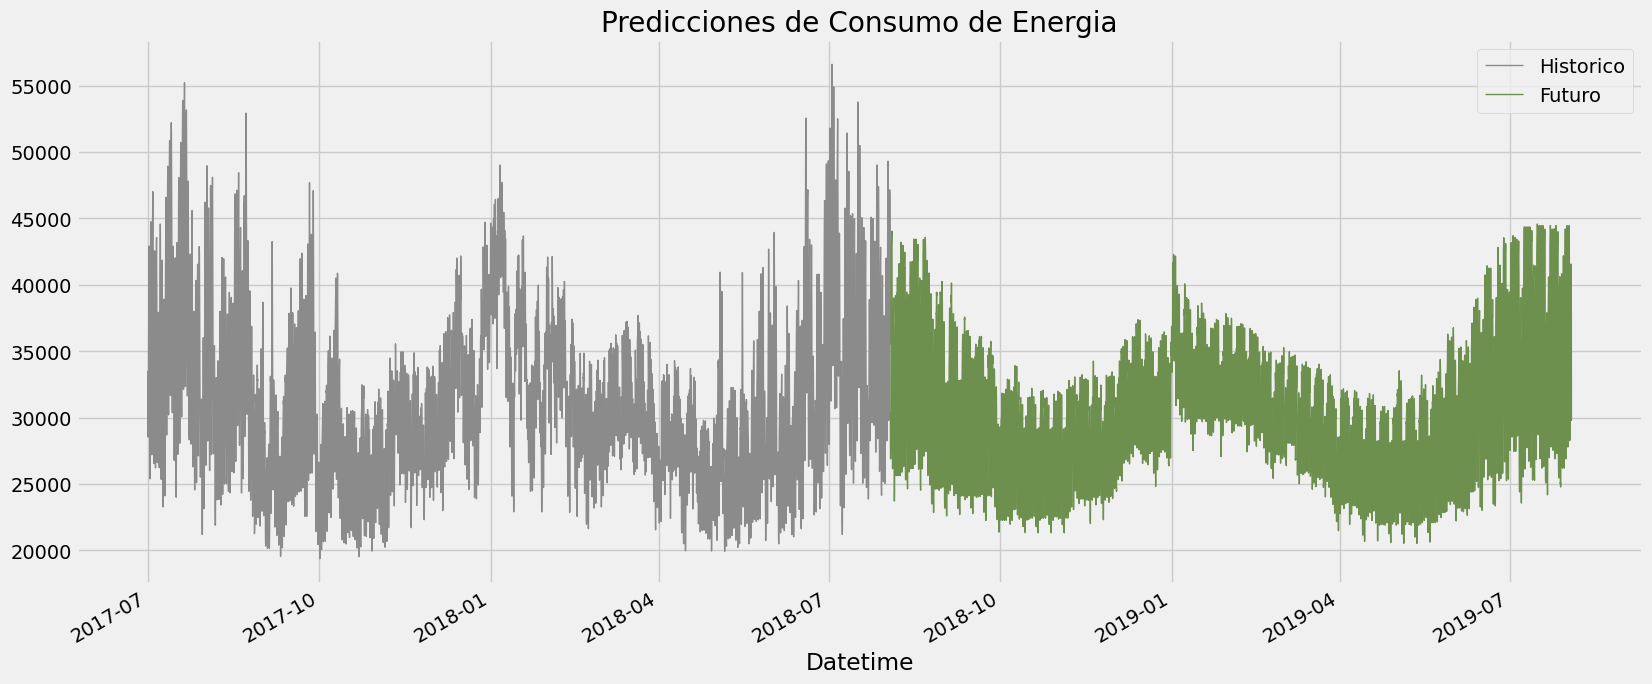

In [145]:
df_2.loc[df_2.index > '2017-07-01' ]['PJME_MW'].plot(color=palet_color[4], ms=1, lw=1,
                                         title='Predicciones de Consumo de Energia')
futuro_con_features['predicciones'].plot( figsize=(18, 8),
                                         color=palet_color[3], ms=1, lw=1,
                                         title='Predicciones de Consumo de Energia')
plt.legend(['Historico', 'Futuro'])
plt.show()

En la gráfica se puede observar los valores predecidos para el periodo futuro establecido [2018-08-03 al 2019-08-03]  

Usando validación cruzada y ajustando los hyperparámetro del modelo tenemos mejores resultados que en el primera sección del proyecto.  

El modelo puede ser mejorado usando y analizando data externa que podría afectar el uso de consumo de energía.